In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

432


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,a79e2e2e2f87d61be25d89e4e3840abb8383b409,fluky-tils,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,1.5,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,...,90,79,53.924051,19.161776,27,41.0,49.0,64.0,103,ccot
1,0b55c81305c470354bc75d13477dcd08a82f52cf,joint-buhl,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,2.0,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,...,84,228,104.907895,19.126413,0,102.0,108.0,114.0,151,ccot
2,832e23107a694cf30e7d73bde1f096ce63c121f1,lamer-choc,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,0.5,ccot/format-thought.txt,cq.txt,auto/ccot.json,...,93,77,56.168831,19.699988,21,39.0,52.0,70.0,99,ccot
3,5041006f00ec1d0ac8d4fd65cdd76145733f22b7,jumpy-yegg,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,1.5,ccot/format-thought.txt,cq.txt,auto/ccot.json,...,95,81,59.604938,21.431682,26,41.0,58.0,76.0,107,ccot
4,13c6888043ddd6633df48d7b8630dba003dd4c56,ruled-ruin,bdsaglam/musique-sweep,answerable,train,llama-3-70b-tgi,0.7,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,...,95,71,54.845070,18.121532,24,41.0,51.0,67.5,98,ccot


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df.head()

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,1,0.646667,0.739779,0.73,0.836478,...,100,80,52.575000,15.572432,26,43.00,49.0,62.0,98,ccot
1,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,2,0.633333,0.742517,0.71,0.831446,...,99,79,54.962025,18.533022,24,43.00,50.0,65.5,100,ccot
2,0.1,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,3,0.643333,0.744104,0.73,0.838430,...,99,79,55.531646,18.243253,27,43.00,50.0,67.5,100,ccot
3,0.5,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,1,0.620000,0.727099,0.70,0.816986,...,97,84,55.797619,16.554241,26,43.75,52.5,65.0,98,ccot
4,0.5,ccot/excellent-format-thought.txt,cq.txt,auto/ccot.json,0,2,0.613333,0.725788,0.72,0.834653,...,89,85,54.741176,16.537226,24,44.00,50.0,65.0,99,ccot


In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) != 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,params.run


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df['params.qa.system_prompt'].unique()

array(['ccot/excellent-format-thought', 'ccot/format-thought',
       'cte/excellent-format-triplets-few', 'cte/format-triplets-few'],
      dtype=object)

In [ ]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
0,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,0.641111,0.742133,0.723333,0.835452,...,57.000000,99.333333,79.333333,54.356224,17.449569,25.666667,43.000000,49.666667,65.000000,99.333333
1,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,0.627778,0.731521,0.713333,0.826240,...,56.000000,93.666667,82.666667,54.314620,16.581218,24.666667,42.916667,50.500000,64.833333,97.666667
2,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.7,0.631111,0.734677,0.716667,0.819466,...,54.750000,95.666667,83.000000,53.941886,17.095895,24.666667,42.750000,50.000000,63.333333,98.000000
3,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,1.0,0.630000,0.734700,0.713333,0.826663,...,55.916667,94.000000,81.333333,53.716463,17.970605,21.000000,41.750000,49.833333,64.083333,99.000000
4,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,1.5,0.576667,0.691900,0.676667,0.790686,...,57.666667,100.000000,95.333333,58.816320,22.351162,24.000000,42.500000,53.333333,73.666667,118.333333


In [9]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
97,cte,cte/excellent-format-triplets-few,cq,auto/cte,6,0.5,0.698889,0.789375,0.760000,0.852405,...,51.250000,94.333333,62.333333,48.366701,15.021856,26.0,37.666667,45.333333,57.00,98.000000
67,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,0.678889,0.778162,0.746667,0.836723,...,52.583333,88.666667,66.666667,51.362789,16.337178,27.0,38.916667,47.500000,61.75,97.333333


## Visualizations

In [10]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["n_shot"].map(str)
    )

    return dataf


In [11]:
def plot_variance(dataf, x='temperature', y='f1', hue='prompt', technique=None, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    if technique:
        dataf = dataf[dataf['technique'] == technique]
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, hue=hue, data=dataf, linewidth=2.5, legend=legend)
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [12]:
prepared_df = prepare_data(df)
zero_shot_mask = prepared_df["n_shot"] == 0
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
0,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,1,0.646667,0.739779,ccot/excellent-format-thought | cq | 0
1,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,2,0.633333,0.742517,ccot/excellent-format-thought | cq | 0
2,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.1,3,0.643333,0.744104,ccot/excellent-format-thought | cq | 0
3,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,1,0.620000,0.727099,ccot/excellent-format-thought | cq | 0
4,ccot,ccot/excellent-format-thought,cq,auto/ccot,0,0.5,2,0.613333,0.725788,ccot/excellent-format-thought | cq | 0
...,...,...,...,...,...,...,...,...,...,...
427,cte,cte/format-triplets-few,cq,auto/cte,9,1.5,2,0.633333,0.730670,cte/format-triplets-few | cq | 9
428,cte,cte/format-triplets-few,cq,auto/cte,9,1.5,3,0.606667,0.720929,cte/format-triplets-few | cq | 9
429,cte,cte/format-triplets-few,cq,auto/cte,9,2.0,1,0.223333,0.247269,cte/format-triplets-few | cq | 9
430,cte,cte/format-triplets-few,cq,auto/cte,9,2.0,2,0.210000,0.248777,cte/format-triplets-few | cq | 9


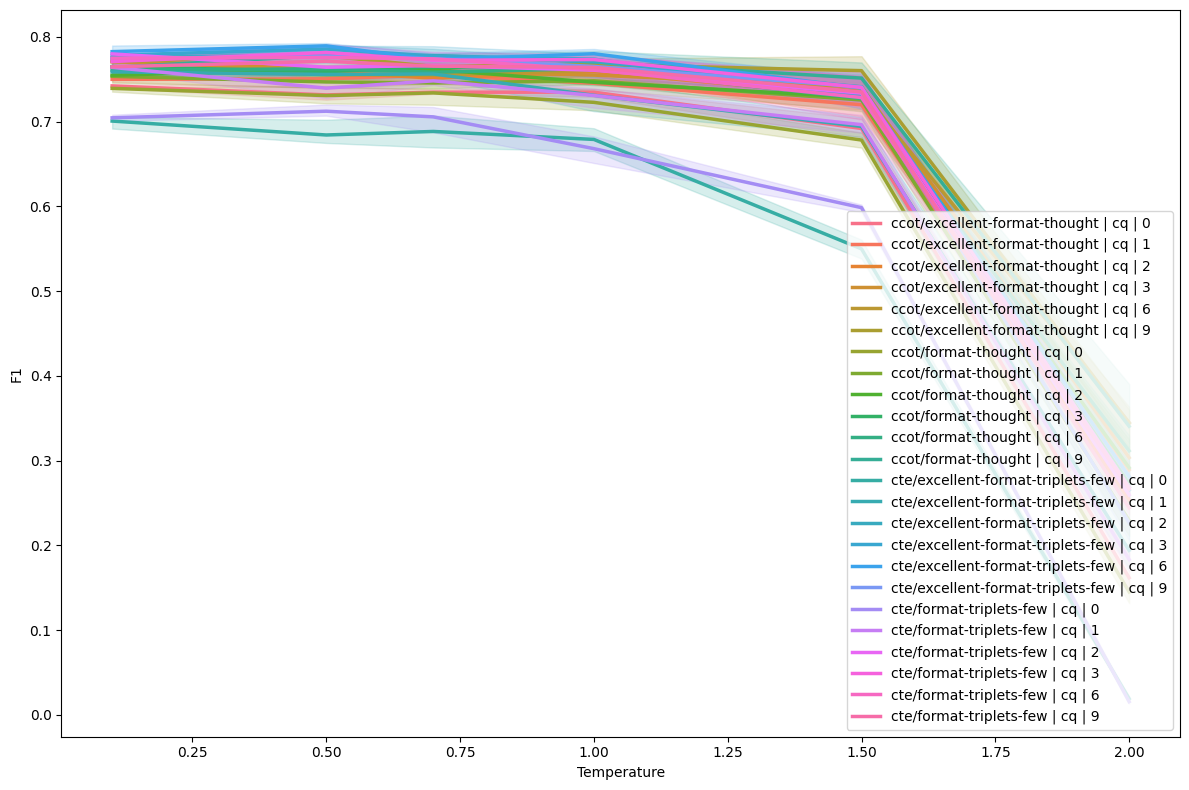

In [13]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [14]:
def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

def one_way_anova_by_nshot(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    
    # Perform One-Way ANOVA at each n-shot
    nshot_values = dataf["n_shot"].unique()
    for nshot in nshot_values:
        _dataf = dataf[dataf["n_shot"] == nshot]
        grouped = _dataf.groupby("technique")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping n-shot {nshot}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for n-shot {nshot:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [15]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # One-Way ANOVA by n-shot
    one_way_anova_by_nshot(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

/tmp/ipykernel_1752795/1818533546.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=legend_loc)


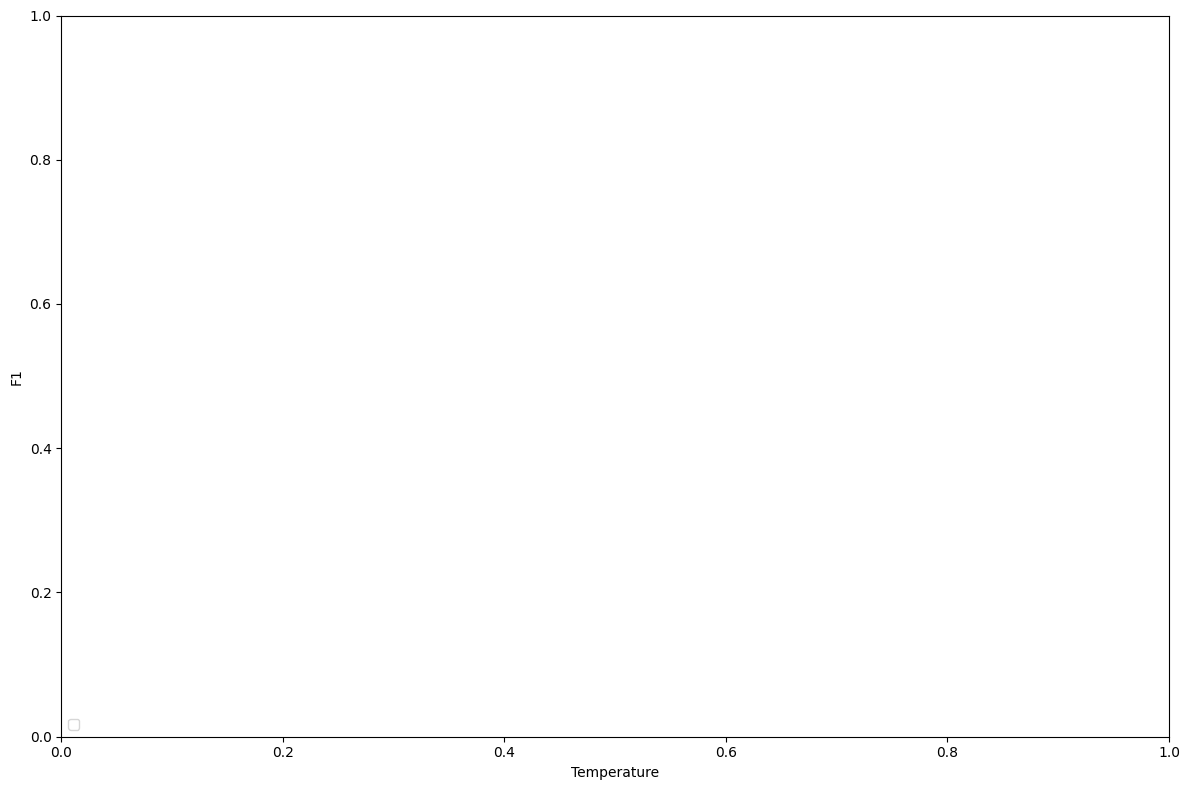

In [16]:
plot_variance(prepared_df, technique='direct', legend='brief')

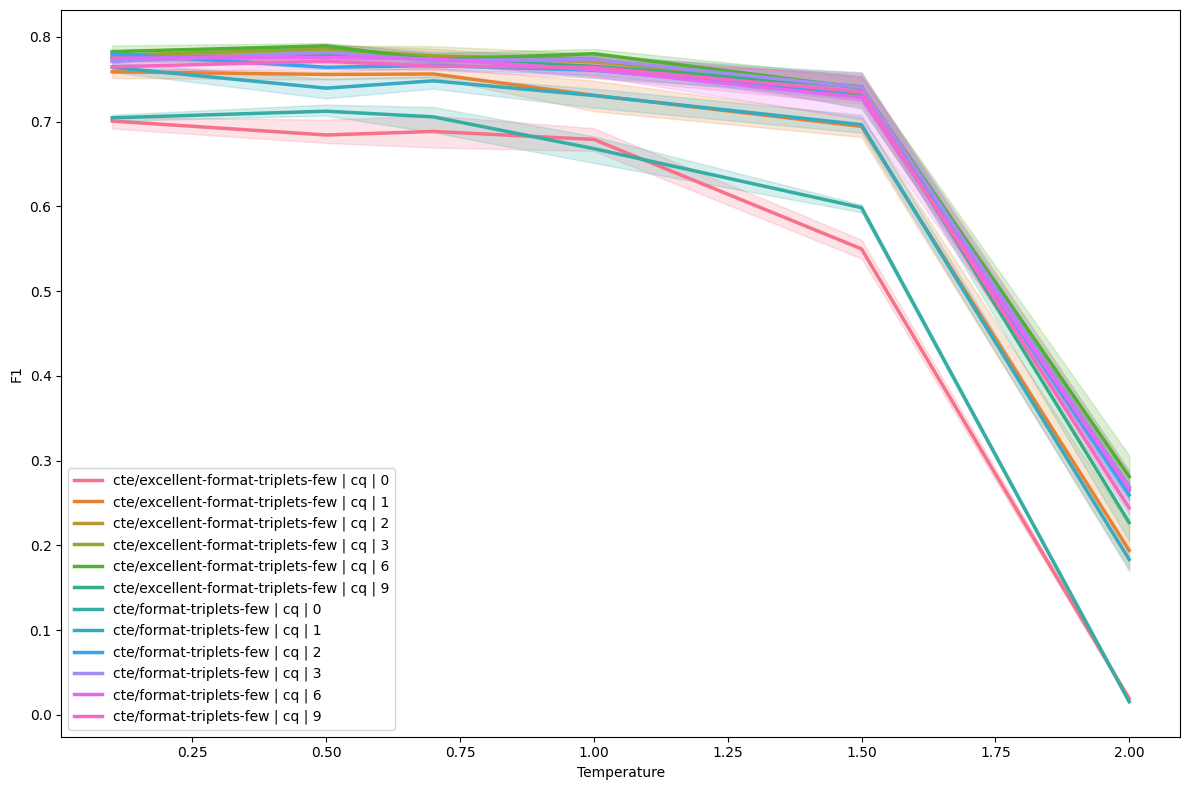

In [17]:
plot_variance(prepared_df, technique='cte', legend='brief')

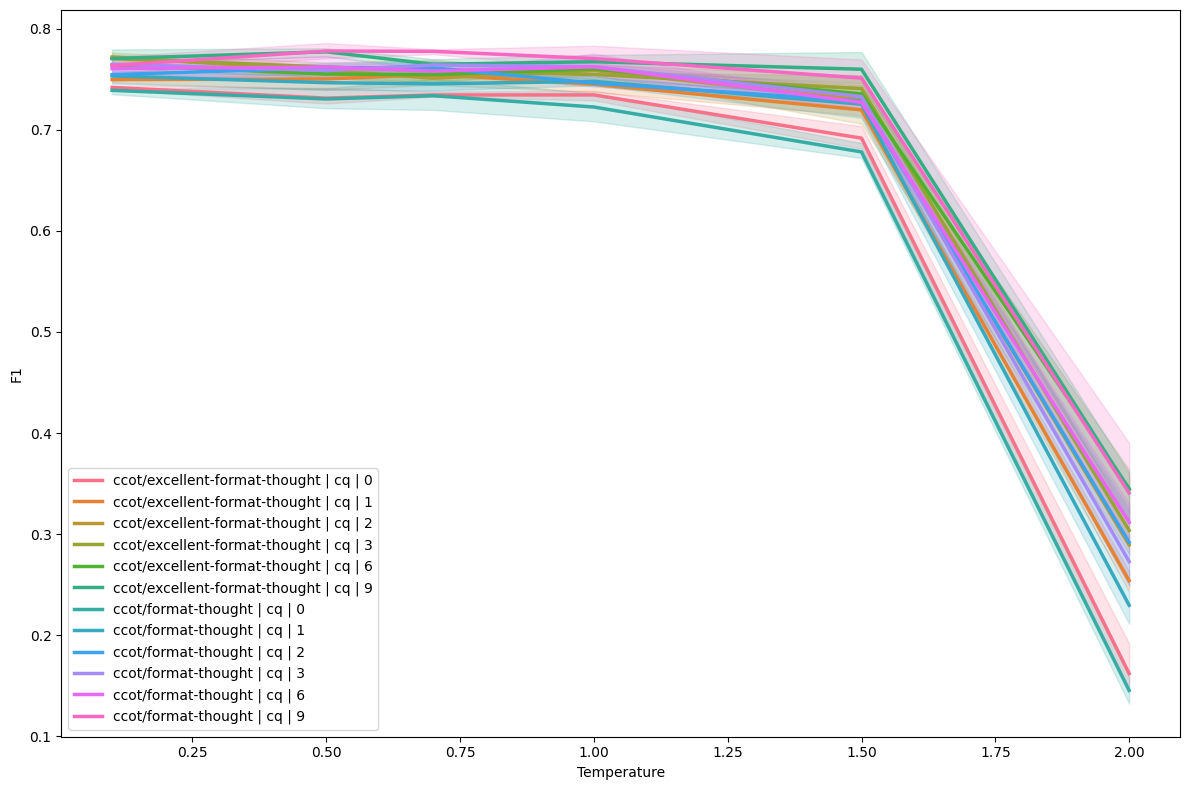

In [18]:
plot_variance(prepared_df, technique='ccot', legend='brief')

In [19]:
report(prepared_df[prepared_df['temperature'] == 0.1])

Prompt values
	 ccot/excellent-format-thought | cq | 0
	 ccot/excellent-format-thought | cq | 1
	 ccot/excellent-format-thought | cq | 2
	 ccot/excellent-format-thought | cq | 3
	 ccot/excellent-format-thought | cq | 6
	 ccot/excellent-format-thought | cq | 9
	 ccot/format-thought | cq | 0
	 ccot/format-thought | cq | 1
	 ccot/format-thought | cq | 2
	 ccot/format-thought | cq | 3
	 ccot/format-thought | cq | 6
	 ccot/format-thought | cq | 9
	 cte/excellent-format-triplets-few | cq | 0
	 cte/excellent-format-triplets-few | cq | 1
	 cte/excellent-format-triplets-few | cq | 2
	 cte/excellent-format-triplets-few | cq | 3
	 cte/excellent-format-triplets-few | cq | 6
	 cte/excellent-format-triplets-few | cq | 9
	 cte/format-triplets-few | cq | 0
	 cte/format-triplets-few | cq | 1
	 cte/format-triplets-few | cq | 2
	 cte/format-triplets-few | cq | 3
	 cte/format-triplets-few | cq | 6
	 cte/format-triplets-few | cq | 9


Temperature values:  0.1


One-Way ANOVA for Temperature 0.1:
F-statisti

                                    Multiple Comparison of Means - Tukey HSD, FWER=0.01                                     
                  group1                                     group2                   meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------------------------------------
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 1   0.0077 0.9606 -0.0114  0.0269  False
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 2   0.0301    0.0   0.011  0.0493   True
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 3   0.0286    0.0  0.0094  0.0478   True
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 6   0.0223 0.0004  0.0031  0.0414   True
    ccot/excellent-format-thought | cq | 0     ccot/excellent-format-thought | cq | 9   0.0285    0.0  0.0094  0.0477   True


### All techniques

In [20]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_df = _data.loc[prompt_mask]
best_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
198,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,1,0.650000,0.762843,ccot/format-thought | cq | 9
199,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,2,0.650000,0.756045,ccot/format-thought | cq | 9
200,ccot,ccot/format-thought,cq,auto/ccot,9,0.1,3,0.660000,0.772530,ccot/format-thought | cq | 9
201,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,1,0.680000,0.786074,ccot/format-thought | cq | 9
202,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,2,0.686667,0.777405,ccot/format-thought | cq | 9
203,ccot,ccot/format-thought,cq,auto/ccot,9,0.5,3,0.670000,0.771008,ccot/format-thought | cq | 9
204,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,1,0.673333,0.774935,ccot/format-thought | cq | 9
205,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,2,0.670000,0.778731,ccot/format-thought | cq | 9
206,ccot,ccot/format-thought,cq,auto/ccot,9,0.7,3,0.673333,0.779894,ccot/format-thought | cq | 9
207,ccot,ccot/format-thought,cq,auto/ccot,9,1.0,1,0.686667,0.783379,ccot/format-thought | cq | 9


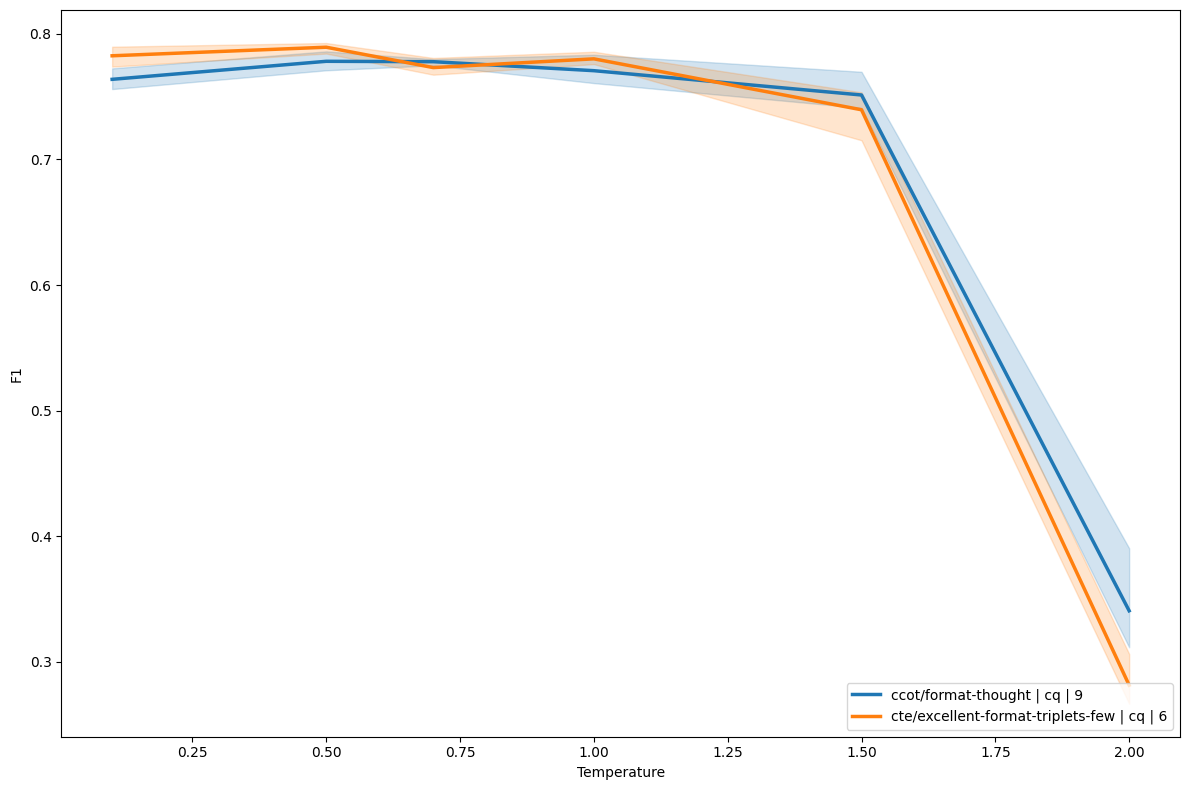

In [21]:
plot_variance(best_prepared_df, figsize=(12, 8), legend_loc='lower right')

In [22]:
report(best_prepared_df)

Prompt values
	 ccot/format-thought | cq | 9
	 cte/excellent-format-triplets-few | cq | 6


Temperature values:  0.1, 0.5, 0.7, 1.0, 1.5, 2.0


One-Way ANOVA for Temperature 0.1:
F-statistic: 7.9424, p-value: 4.7914e-02
One-Way ANOVA for Temperature 0.5:
F-statistic: 4.9038, p-value: 9.1172e-02
One-Way ANOVA for Temperature 0.7:
F-statistic: 1.2234, p-value: 3.3074e-01
One-Way ANOVA for Temperature 1.0:
F-statistic: 1.6766, p-value: 2.6506e-01
One-Way ANOVA for Temperature 1.5:
F-statistic: 0.5912, p-value: 4.8486e-01
One-Way ANOVA for Temperature 2.0:
F-statistic: 4.4912, p-value: 1.0143e-01


Skipping n-shot 9: Not enough groups to perform ANOVA
Skipping n-shot 6: Not enough groups to perform ANOVA


                            Multiple Comparison of Means - Tukey HSD, FWER=0.01                             
           group1                              group2                   meandiff p-adj  lower  upper  reject
----------------------------------------------------------------------

## Inspect

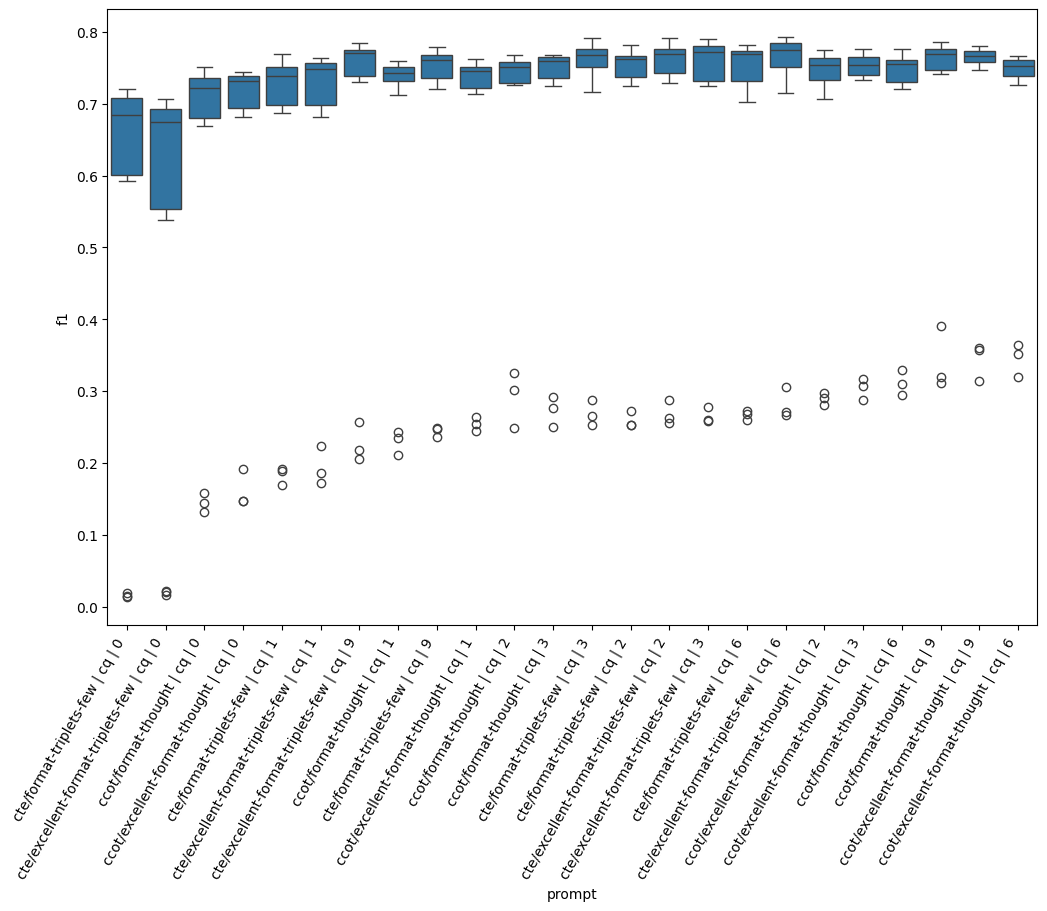

In [23]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.sort_values(by="f1"),
)
plt.xticks(rotation=60, ha="right");

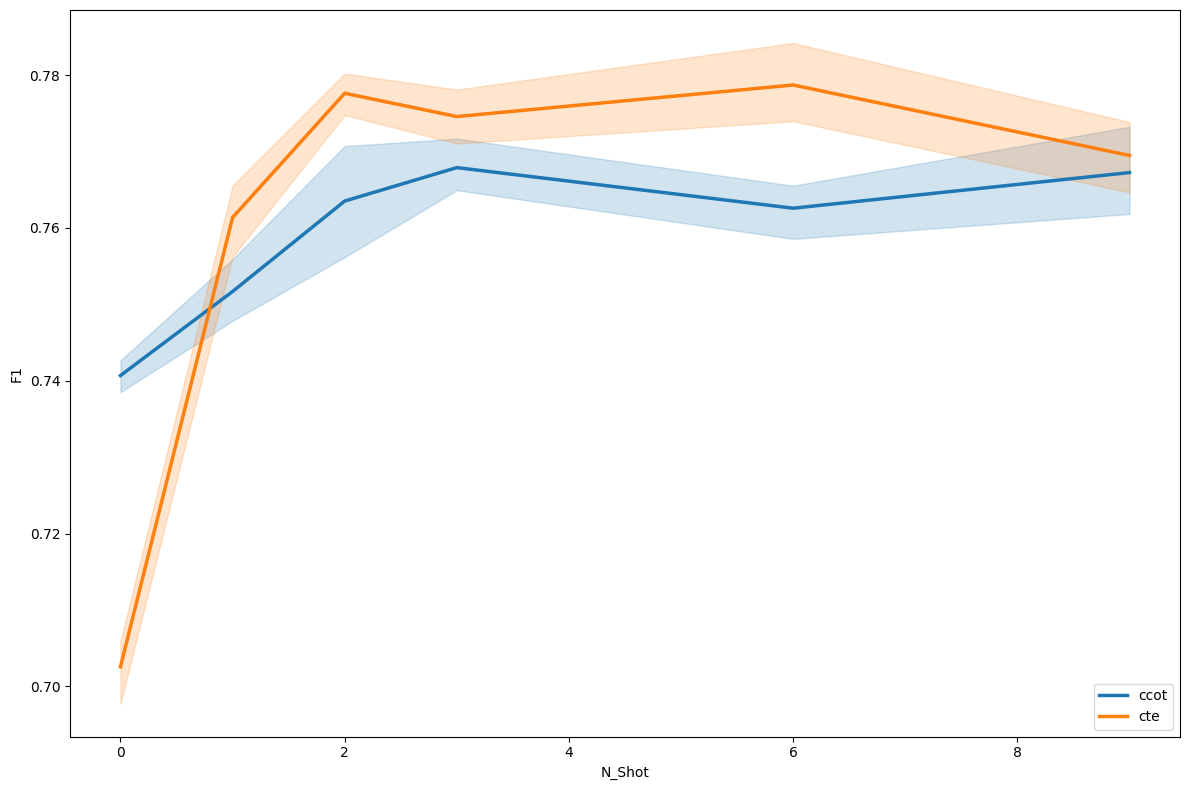

In [24]:
plot_variance(prepared_df[prepared_df['temperature'] == 0.1], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [25]:
prepared_df['temperature'].unique()

array([0.1, 0.5, 0.7, 1. , 1.5, 2. ])

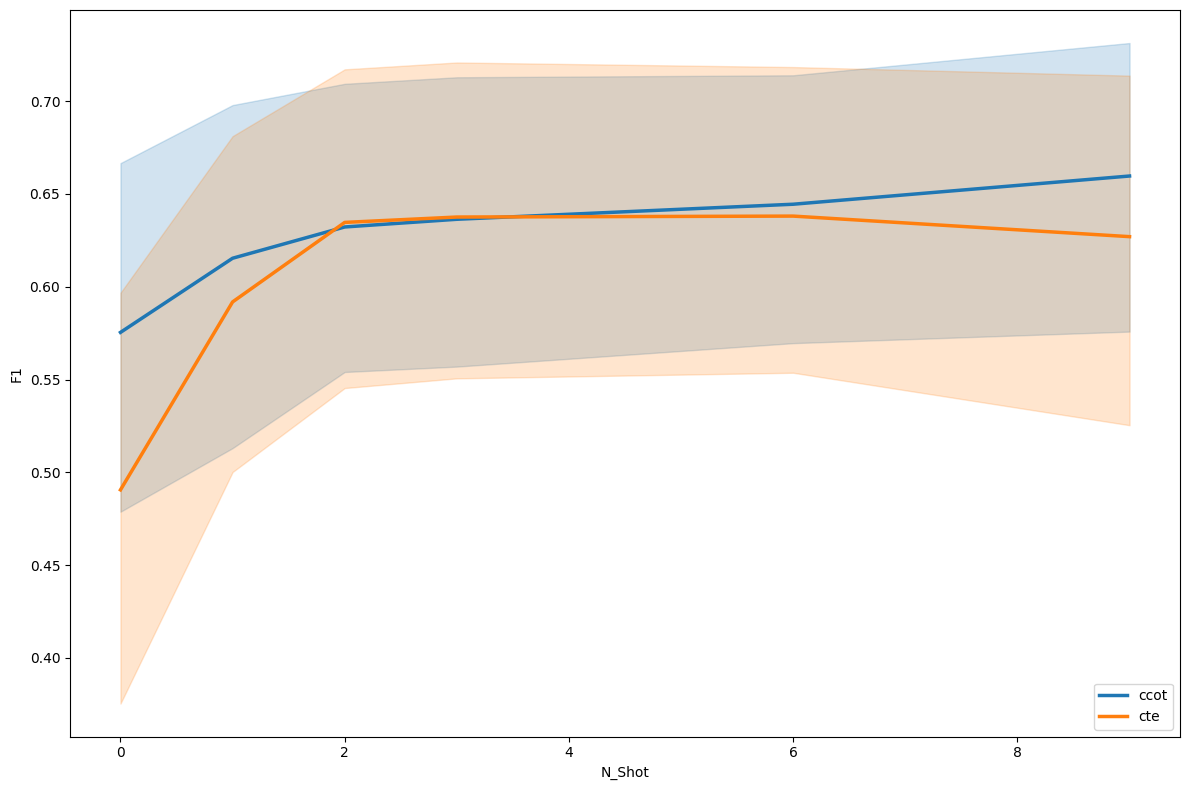

In [26]:
plot_variance(prepared_df[prepared_df['temperature'] > 0.6], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [27]:
df

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,1,0.646667,0.739779,0.73,0.836478,...,100,80,52.575000,15.572432,26,43.00,49.0,62.00,98,ccot
1,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,2,0.633333,0.742517,0.71,0.831446,...,99,79,54.962025,18.533022,24,43.00,50.0,65.50,100,ccot
2,0.1,ccot/excellent-format-thought,cq,auto/ccot,0,3,0.643333,0.744104,0.73,0.838430,...,99,79,55.531646,18.243253,27,43.00,50.0,67.50,100,ccot
3,0.5,ccot/excellent-format-thought,cq,auto/ccot,0,1,0.620000,0.727099,0.70,0.816986,...,97,84,55.797619,16.554241,26,43.75,52.5,65.00,98,ccot
4,0.5,ccot/excellent-format-thought,cq,auto/ccot,0,2,0.613333,0.725788,0.72,0.834653,...,89,85,54.741176,16.537226,24,44.00,50.0,65.00,99,ccot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.5,cte/format-triplets-few,cq,auto/cte,9,2,0.633333,0.730670,0.72,0.810243,...,90,87,55.137931,20.151272,15,39.00,52.0,65.50,106,cte
428,1.5,cte/format-triplets-few,cq,auto/cte,9,3,0.606667,0.720929,0.69,0.802707,...,93,87,57.114943,20.429929,26,41.00,51.0,65.50,110,cte
429,2.0,cte/format-triplets-few,cq,auto/cte,9,1,0.223333,0.247269,0.46,0.487526,...,104,230,103.178261,24.720595,0,103.00,109.0,115.00,140,cte
430,2.0,cte/format-triplets-few,cq,auto/cte,9,2,0.210000,0.248777,0.33,0.375741,...,73,232,103.939655,24.467591,0,104.00,109.0,114.25,148,cte
